# 2024 CITS4012 Project

# Readme

notes for marker

# 1. Dataset Processing

## Import the libraries

In [1]:
import re
import json
import nltk
import spacy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt

In [64]:
import time
import math

# Helper functions for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

## Loading the datasets

In [91]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Load the training data
# with open('/content/drive/MyDrive/data/train.json', 'r') as file:
with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
# with open('/content/drive/MyDrive/data/test.json', 'r') as file:
with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
# with open('/content/drive/MyDrive/data/val.json', 'r') as file:
with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist() + val_data['sentence'].tolist()
training_a = train_data['aspect'].tolist() + val_data['aspect'].tolist()
training_y = train_data['polarity'].tolist() + val_data['polarity'].tolist()
# output_y = [["<BOS>"] + [y] for y in training_y]
# target_y = [[y] + ["<EOS>"]for y in training_y]
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [3]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Sentiment Distribution
sentiment_distribution = train_data['polarity'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7978
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Sentiment Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)         

## Data Preprocessing

In [4]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 325.1 kB/s eta 0:00:40
     --------------------------------------- 0.1/12.8 MB 655.4 kB/s eta 0:00:20
     - -------------------------------------- 0.3/12.8 MB 1.9 MB/s eta 0:00:07
     - -------------------------------------- 0.6/12.8 MB 2.8 MB/s eta 0:00:05
     -- ------------------------------------- 0.9/12.8 MB 3.2 MB/s eta 0:00:04
     --- ------------------------------------ 1.1/12.8 MB 3.6 MB/s eta 0:00:04
     ---- ----------------------------------- 1.4/12.8 MB 3.9 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 4.1 MB/s eta 0:00:03
     ------ --------------------------------- 1.9/12.8 MB 4.3 MB/s eta 0:00:03
     ------ --------------------------------- 2.2/12.8 MB 4.5 MB/s eta 0:00:03
     ------- -------------------------------- 2.3/12.8 MB 4.5 MB

In [5]:
# Punctuation Removal
def remove_punctuation_re(x):
    x = re.sub(r'[^\w\s]', '', x)
    return x

nltk.download('punkt')

# Stopwords Removal
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(x):
    doc = nlp(x)
    x = [word.text for word in doc if not word.is_stop]
    return x

# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem(x):
    x = [stemmer.stem(word) for word in x]
    return x

# Lemmatisation
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    x = [lemmatizer.lemmatize(word) for word in x]
    return x

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = remove_punctuation_re(sentence)      # Remove punctuation
        tokens = remove_stopwords(sentence)             # Remove stopwords / Tokenise
        # tokens = stem(tokens)                           # Stemming
        # tokens = lemmatize(tokens)                      # Lemmatisation
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)

In [7]:
# Get longest sentence length
longest_sentence = max(train_x_token, key=len)
MAX_LENGTH = len(longest_sentence)

# Word vocabulary to index dictionary {word: index}
word_to_idx = {'<PAD>': 0, '<SEP>': 1}
review = train_x_token + test_x_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]

# Vocabulary includes words from reviews and aspects
for sentence in aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
word_list = list(word_to_idx.keys())
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

# Polarity vocabulary to index dictionary {polarity: index}
polarity_to_idx = {p: i for i, p in enumerate(polarity[0])}
idx_to_polarity = {idx: pol for pol, idx in polarity_to_idx.items()}

In [8]:
def list_to_index(token_list, word_to_idx):
    idx_list = []
    for tokens in token_list:
        idx_list.append([word_to_idx[token] for token in tokens])
    return idx_list

def string_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

# Token index lists for training data
train_x_idx = list_to_index(train_x_token, word_to_idx)
train_a_idx = string_to_index(training_a, word_to_idx)
train_y_idx = string_to_index(training_y, polarity_to_idx)

## Pretrained Word Embeddings from Glove

In [14]:
glove_model = api.load("glove-twitter-50")
glove_weights = torch.FloatTensor(glove_model.vectors)

# 2. Model Implementation

## Model 1

In [54]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, hidden_size, embedding, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        
    def forward(self, input, hidden, aspect):
        word_embedding = self.embedding(input).view(1, 1, -1)
        aspect_embedding = self.embedding(aspect).view(1, 1, -1)
        word_embedding = torch.cat((aspect_embedding, word_embedding), 0)
        output, (hidden, cell) = self.lstm(word_embedding)
        return output, hidden, cell
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention='dot_product'):
        super(Decoder, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.linear = nn.Linear(self.hidden_size*2, self.output_size)
    
    def cal_attention(self, hidden, encoder_hiddens):
        if self.attention_type == 'dot_product':            # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        elif self.attention_type == 'scaled_dot_product':   # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)) * scale, dim=-1)
        elif self.attention_type == 'cosine_similarity':
            query = hidden / torch.norm(hidden, dim=-1)
            keys = encoder_hiddens / torch.norm(encoder_hiddens.T, dim=-1)
            norm_product = torch.bmm(query, keys.T.unsqueeze(0))
            attn_weights = F.softmax(norm_product, dim=-1)

        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output
    
    def forward(self, hidden, encoder_hiddens):
        concat_output = self.cal_attention(hidden, encoder_hiddens)
        output = F.log_softmax(self.linear(concat_output), dim=1)
        return output

In [73]:
# Set the seed for reproducibility
# seed = 4012
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

num_epochs = 10000
print_interval = 500
plot_interval = 200
learning_rate = 0.001
hidden_size = 64
attention_type = 'dot_product' # 'dot_product', 'scaled_dot_product', 'cosine_similarity'

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

encoder = Encoder(hidden_size, embedding, num_layers=1)
decoder = Decoder(hidden_size, 3, attention=attention_type)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
plot_all_losses, plot_avg_losses, print_loss_total, plot_loss_total = [], [], 0, 0
start = time.time()

for epoch in range(1, num_epochs+1):
    random_idx = random.choice(range(len(train_data)))
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    y_index = train_y_idx[random_idx]
    a_index = train_a_idx[random_idx]
    
    x_tensor = torch.LongTensor(x_index)
    y_tensor = torch.LongTensor([y_index])
    a_tensor = torch.LongTensor([a_index])
    x_length = x_tensor.size(0)

    loss = 0
    encoder.train()
    decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Feed the x_tensor (sentence) into the encoder
    encoder_hiddens = torch.zeros(MAX_LENGTH, encoder.hidden_size) # For attention mechanism
    encoder_hidden = encoder.init_hidden() # Hidden state for encoder
    for i in range(x_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(x_tensor[i], encoder_hidden, a_tensor)
        encoder_hiddens[i] = encoder_hidden[0, 0]

    y_output = decoder(encoder_hidden, encoder_hiddens)
    loss += criterion(y_output, y_tensor)

    # Backpropagation
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    print_loss_total += loss.item()
    plot_loss_total += loss.item()
    plot_all_losses.append(loss.item())
    
    if epoch % print_interval == 0:
        print_avg_loss = print_loss_total / print_interval
        print_time = timeSince(start, epoch / num_epochs)
        print(f'{print_time} Epoch [{epoch}/{num_epochs}] Loss: {print_avg_loss:.4f}')
        print_loss_total = 0
        
    if epoch % plot_interval == 0:
        plot_avg_loss = plot_loss_total / plot_interval
        plot_avg_losses.append(plot_avg_loss)
        plot_loss_total = 0

0m 15s (- 4m 59s) Epoch [500/10000] Loss: 0.9892
0m 31s (- 4m 41s) Epoch [1000/10000] Loss: 0.9663
0m 47s (- 4m 27s) Epoch [1500/10000] Loss: 0.9514
1m 1s (- 4m 6s) Epoch [2000/10000] Loss: 0.9305
1m 16s (- 3m 49s) Epoch [2500/10000] Loss: 0.9204
1m 32s (- 3m 34s) Epoch [3000/10000] Loss: 0.9354
1m 46s (- 3m 18s) Epoch [3500/10000] Loss: 0.9217
2m 1s (- 3m 2s) Epoch [4000/10000] Loss: 0.8570
2m 15s (- 2m 46s) Epoch [4500/10000] Loss: 0.8999
2m 30s (- 2m 30s) Epoch [5000/10000] Loss: 0.8691
2m 46s (- 2m 16s) Epoch [5500/10000] Loss: 0.8541
3m 1s (- 2m 1s) Epoch [6000/10000] Loss: 0.8423
3m 16s (- 1m 45s) Epoch [6500/10000] Loss: 0.8907
3m 33s (- 1m 31s) Epoch [7000/10000] Loss: 0.8212
4m 0s (- 1m 20s) Epoch [7500/10000] Loss: 0.8015
4m 24s (- 1m 6s) Epoch [8000/10000] Loss: 0.8521
4m 45s (- 0m 50s) Epoch [8500/10000] Loss: 0.7937
5m 10s (- 0m 34s) Epoch [9000/10000] Loss: 0.8277
5m 41s (- 0m 17s) Epoch [9500/10000] Loss: 0.7799
6m 10s (- 0m 0s) Epoch [10000/10000] Loss: 0.7817


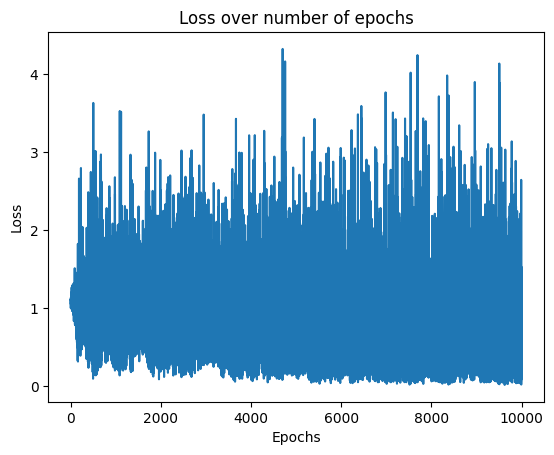

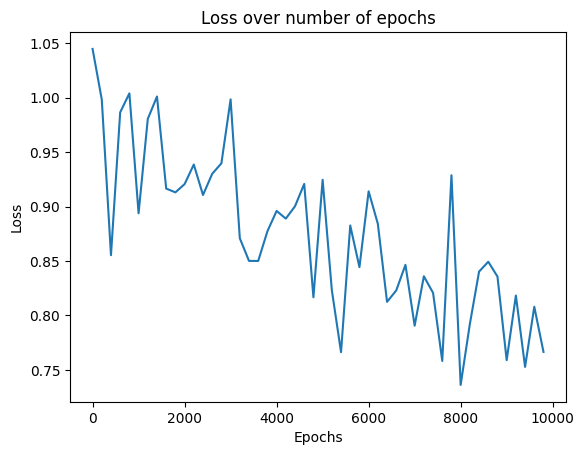

In [74]:
# Save the model
# torch.save(encoder, 'Model/encoder1.pt')
# torch.save(decoder, 'Model1/decoder1.pt')

# Plot loss over number of epochs
plt.plot(range(1, num_epochs+1), plot_all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

plt.plot(range(1, num_epochs+1, plot_interval), plot_avg_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

# 3. Testing and Evaluation

## Model 1

In [84]:
# LSTM evaluate
def LSTMevaluate(encoder, decoder, sentence, aspect, max_length=MAX_LENGTH):
    with torch.no_grad():
        input = preprocess_data([sentence])[0]
        input_idx = [word_to_idx[word] for word in input]
        input_tensor = torch.LongTensor([[ind] for ind in input_idx])
        
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()
        
        asp_idx = word_to_idx[aspect]
        asp_tensor = torch.LongTensor([[asp_idx]])
        
        print(input_idx)
        print(asp_idx)
        print(input_tensor)
        print(asp_tensor)
        return

        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            _, encoder_hidden, _ = encoder(input_tensor[ei], encoder_hidden, asp_tensor)
            encoder_hiddens[ei] += encoder_hidden[0, 0]
        
        y_pred = decoder(encoder_hidden, encoder_hiddens)
        topv, topi = y_pred.data.topk(1)
        return idx_to_polarity[topi.item()]

In [85]:
# Measure accuracy of LSTM model on test set
correct = 0
for i in range(len(test_x)):
    polarity = LSTMevaluate(encoder, decoder, test_x[i], test_a[i])
    if polarity == test_y[i]:
        correct += 1
accuracy = correct / len(test_x_token)
print(f"Accuracy: {accuracy:.4f}")

[173, 655, 184, 165, 1189, 4837, 6995, 3279, 290, 1904, 1022, 6996, 1189, 1904, 669, 811, 6997, 4175, 6998]
7
tensor([[ 173],
        [ 655],
        [ 184],
        [ 165],
        [1189],
        [4837],
        [6995],
        [3279],
        [ 290],
        [1904],
        [1022],
        [6996],
        [1189],
        [1904],
        [ 669],
        [ 811],
        [6997],
        [4175],
        [6998]])
tensor([[7]])
[173, 655, 184, 165, 1189, 4837, 6995, 3279, 290, 1904, 1022, 6996, 1189, 1904, 669, 811, 6997, 4175, 6998]
3
tensor([[ 173],
        [ 655],
        [ 184],
        [ 165],
        [1189],
        [4837],
        [6995],
        [3279],
        [ 290],
        [1904],
        [1022],
        [6996],
        [1189],
        [1904],
        [ 669],
        [ 811],
        [6997],
        [4175],
        [6998]])
tensor([[3]])
[3, 142, 1428, 3388, 4905, 6]
3
tensor([[   3],
        [ 142],
        [1428],
        [3388],
        [4905],
        [   6]])
tensor([[3]])

KeyboardInterrupt: 

In [77]:
# Append aspect to the end of the sentence
def combine_sentence_aspect(sentence, aspect):
    sep_idx = word_to_idx['<SEP>']
    combined_idx = sentence + [sep_idx] + [aspect]
    return combined_idx

train_xa_idx = []
for x, a in zip(train_x_idx, train_a_idx):
    train_xa_idx.append(combine_sentence_aspect(x, a))
    
# Get the longest sentence length after appending aspect
longest_combined_sentence = max(train_xa_idx, key=len)
MAX_COMBINED_LENGTH = len(longest_combined_sentence)

In [78]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, hidden_size, embedding, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        
    def forward(self, input, hidden):
        word_embedding = self.embedding(input).view(1, 1, -1)
        output, (hidden, cell) = self.lstm(word_embedding)
        return output, hidden, cell
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention='dot_product'):
        super(Decoder, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.linear = nn.Linear(self.hidden_size*2, self.output_size)
    
    def cal_attention(self, hidden, encoder_hiddens):
        if self.attention_type == 'dot_product':            # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        elif self.attention_type == 'scaled_dot_product':   # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)) * scale, dim=-1)
        elif self.attention_type == 'cosine_similarity':
            query = hidden / torch.norm(hidden, dim=-1)
            keys = encoder_hiddens / torch.norm(encoder_hiddens.T, dim=-1)
            norm_product = torch.bmm(query, keys.T.unsqueeze(0))
            attn_weights = F.softmax(norm_product, dim=-1)

        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output
    
    def forward(self, hidden, encoder_hiddens):
        concat_output = self.cal_attention(hidden, encoder_hiddens)
        output = F.log_softmax(self.linear(concat_output), dim=1)
        return output

In [17]:
# Set the seed for reproducibility
# seed = 4012
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

num_epochs = 10000
display_interval = 500
learning_rate = 0.01
hidden_size = 50
attention_type = 'dot_product' # 'dot_product', 'scaled_dot_product', 'cosine_similarity'

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

encoder = Encoder(hidden_size, embedding, num_layers=1)
decoder = Decoder(hidden_size, 3, attention=attention_type)

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
plot_losses = []
plot_avg_losses = []
total_loss = 0

for epoch in range(1, num_epochs+1):
    random_idx = random.choice(range(len(train_data)))
    x_index = train_x_idx[random_idx]
    a_index = train_a_idx[random_idx]
    y_index = train_y_idx[random_idx]

    xa_combined = combine_sentence_aspect(x_index, a_index)
    xa_index = [[idx] for idx in xa_combined]
    
    xa_tensor = torch.LongTensor(xa_index)
    y_tensor = torch.LongTensor([y_index])
    
    xa_length = xa_tensor.size(0)

    loss = 0
    encoder.train()
    decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Feed the x_tensor (sentence) into the encoder
    encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH, encoder.hidden_size) # For attention mechanism
    encoder_hidden = encoder.init_hidden() # Hidden state for encoder
    for i in range(xa_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(xa_tensor[i], encoder_hidden)
        encoder_hiddens[i] = encoder_hidden[0, 0]

    y_output = decoder(encoder_hidden, encoder_hiddens)
    loss += criterion(y_output, y_tensor)

    # Backpropagation
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    loss = loss.item()
    total_loss += loss
    plot_losses.append(loss)
    
    if (epoch+1) % display_interval == 0:
        avg_loss = total_loss / display_interval
        plot_avg_losses.append(avg_loss)
        total_loss = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [500/10000], Loss: 1.0441
Epoch [1000/10000], Loss: 0.9513
Epoch [1500/10000], Loss: 0.9248
Epoch [2000/10000], Loss: 0.9314
Epoch [2500/10000], Loss: 0.9260
Epoch [3000/10000], Loss: 0.9459
Epoch [3500/10000], Loss: 0.9180
Epoch [4000/10000], Loss: 0.9286
Epoch [4500/10000], Loss: 0.9201
Epoch [5000/10000], Loss: 0.9369
Epoch [5500/10000], Loss: 0.9294
Epoch [6000/10000], Loss: 0.9075
Epoch [6500/10000], Loss: 0.9232
Epoch [7000/10000], Loss: 0.9397
Epoch [7500/10000], Loss: 0.9282
Epoch [8000/10000], Loss: 0.9234
Epoch [8500/10000], Loss: 0.9786
Epoch [9000/10000], Loss: 0.9271
Epoch [9500/10000], Loss: 0.9101
Epoch [10000/10000], Loss: 0.9459


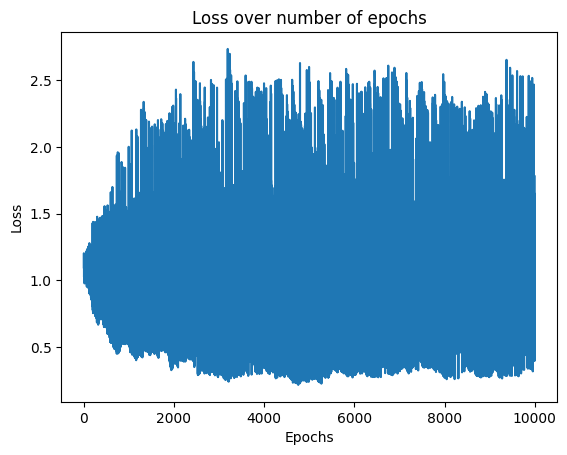

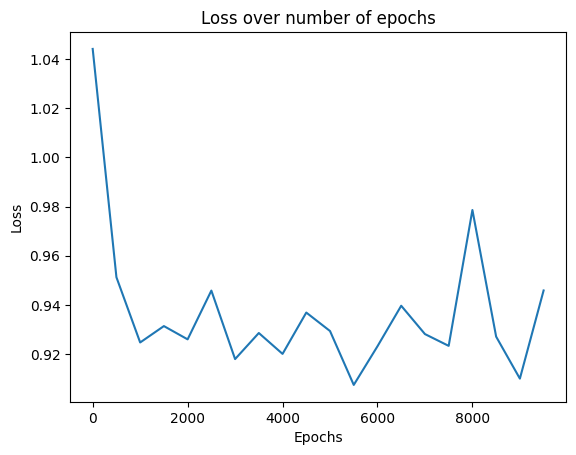

In [18]:
# Save the model
# torch.save(encoder, 'Model/encoder1.pt')
# torch.save(decoder, 'Model1/decoder1.pt')

# Plot loss over number of epochs
plt.plot(range(1, num_epochs+1), plot_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

plt.plot(range(1, num_epochs+1, display_interval), plot_avg_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

In [19]:
# LSTM evaluate
def LSTMevaluate(encoder, decoder, sentence, aspect, max_length=MAX_LENGTH):
    with torch.no_grad():
        sent = preprocess_data([sentence])[0]
        sent_idx = [word_to_idx[word] for word in sent]
        asp_idx = word_to_idx[aspect]
        
        input_idx = combine_sentence_aspect(sent_idx, asp_idx)
        input_tensor = torch.LongTensor([[ind] for ind in input_idx])
        input_length = input_tensor.size(0)
        
        encoder_hidden = encoder.init_hidden()
        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            _, encoder_hidden, _ = encoder(input_tensor[ei], encoder_hidden)
            encoder_hiddens[ei] += encoder_hidden[0, 0]
        
        y_pred = decoder(encoder_hidden, encoder_hiddens)
        topv, topi = y_pred.data.topk(1)
        return idx_to_polarity[topi.item()]

In [20]:
# Measure accuracy of LSTM model on test set
correct = 0
for i in range(len(test_x)):
    polarity = LSTMevaluate(encoder, decoder, test_x[i], test_a[i])
    if polarity == test_y[i]:
        correct += 1
accuracy = correct / len(test_x_token)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5871


## Model 2

In [78]:
# Add paddings
def add_paddings(sentence, max_seq_length):
    return sentence + ['<PAD>'] * (max_seq_length - len(sentence))

# Prepare batch for training
def prepare_batch(sentences, aspects, batch_size):
    indices = random.sample(range(len(sentences)), batch_size)
    input_batch = []
    aspect_batch = []
    for idx in indices:
        input = [[i] for i in sentences[idx]]
        aspect = aspects[idx]
        input_tensor = torch.LongTensor([[ind] for ind in input])
        aspect_tensor = torch.LongTensor([aspect])
        input_batch.append(input_tensor)
        aspect_batch.append(aspect_tensor)
    return input_batch, aspect_batch
    
train_x_padded = [add_paddings(sentence, MAX_LENGTH) for sentence in train_x_token]
train_x_idx = list_to_index(train_x_padded, word_to_idx)
input_batch, aspect_batch = prepare_batch(train_x_idx, train_a_idx, 5)

In [9]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, hidden_size, embedding, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        
    def forward(self, input, hidden):
        word_embedding = self.embedding(input).view(1, 1, -1)
        output, (hidden, cell) = self.lstm(word_embedding)
        return output, hidden, cell
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention='dot_product'):
        super(Decoder, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.linear = nn.Linear(self.hidden_size*2, self.output_size)
    
    def cal_attention(self, hidden, encoder_hiddens):
        if self.attention_type == 'dot_product':            # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        elif self.attention_type == 'scaled_dot_product':   # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)) * scale, dim=-1)
        elif self.attention_type == 'cosine_similarity':
            query = hidden / torch.norm(hidden, dim=-1)
            keys = encoder_hiddens / torch.norm(encoder_hiddens.T, dim=-1)
            norm_product = torch.bmm(query, keys.T.unsqueeze(0))
            attn_weights = F.softmax(norm_product, dim=-1)

        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output
    
    def forward(self, hidden, encoder_hiddens):
        concat_output = self.cal_attention(hidden, encoder_hiddens)
        output = F.log_softmax(self.linear(concat_output), dim=1)
        return output

In [14]:
# Set the seed for reproducibility
# seed = 4012
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

num_epochs = 10000
display_interval = 500
learning_rate = 0.01
hidden_size = 50
attention_type = 'dot_product' # 'dot_product', 'scaled_dot_product', 'cosine_similarity'

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

encoder = Encoder(hidden_size, embedding, num_layers=1)
decoder = Decoder(hidden_size, 3, attention=attention_type)

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
plot_losses = []
plot_avg_losses = []
total_loss = 0

for epoch in range(1, num_epochs+1):
    random_idx = random.choice(range(len(train_data)))
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    y_index = train_y_idx[random_idx]
    a_index = train_a_idx[random_idx]
    
    x_tensor = torch.LongTensor(x_index)
    y_tensor = torch.LongTensor([y_index])
    a_tensor = torch.LongTensor([a_index])
    x_length = x_tensor.size(0)

    loss = 0
    encoder.train()
    decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Feed the x_tensor (sentence) into the encoder
    encoder_hiddens = torch.zeros(MAX_LENGTH, encoder.hidden_size) # For attention mechanism
    encoder_hidden = encoder.init_hidden() # Hidden state for encoder
    for i in range(x_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(x_tensor[i], encoder_hidden)
        encoder_hiddens[i] = encoder_hidden[0, 0]

    y_output = decoder(encoder_hidden, encoder_hiddens)
    loss += criterion(y_output, y_tensor)

    # Backpropagation
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    loss = loss.item()
    total_loss += loss
    plot_losses.append(loss)
    
    if (epoch+1) % display_interval == 0:
        avg_loss = total_loss / display_interval
        plot_avg_losses.append(avg_loss)
        total_loss = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [500/10000], Loss: 1.0803
Epoch [1000/10000], Loss: 1.0698
Epoch [1500/10000], Loss: 1.0876
Epoch [2000/10000], Loss: 1.0709
Epoch [2500/10000], Loss: 1.0839
Epoch [3000/10000], Loss: 1.0713
Epoch [3500/10000], Loss: 1.0818
Epoch [4000/10000], Loss: 1.0577
Epoch [4500/10000], Loss: 1.0800
Epoch [5000/10000], Loss: 1.0596
Epoch [5500/10000], Loss: 1.0587
Epoch [6000/10000], Loss: 1.0701
Epoch [6500/10000], Loss: 1.0723
Epoch [7000/10000], Loss: 1.0807
Epoch [7500/10000], Loss: 1.0714
Epoch [8000/10000], Loss: 1.0610
Epoch [8500/10000], Loss: 1.0773
Epoch [9000/10000], Loss: 1.0748
Epoch [9500/10000], Loss: 1.0684
Epoch [10000/10000], Loss: 1.0664


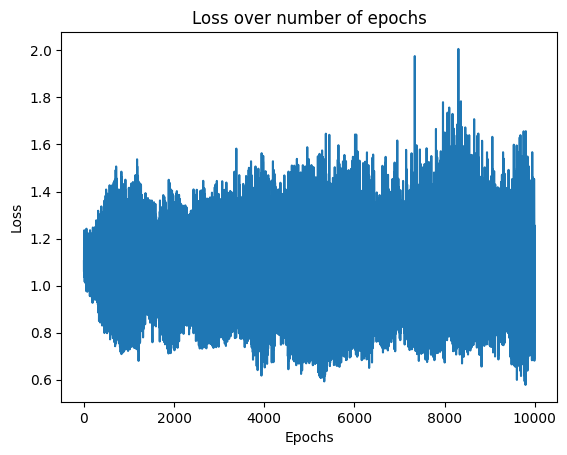

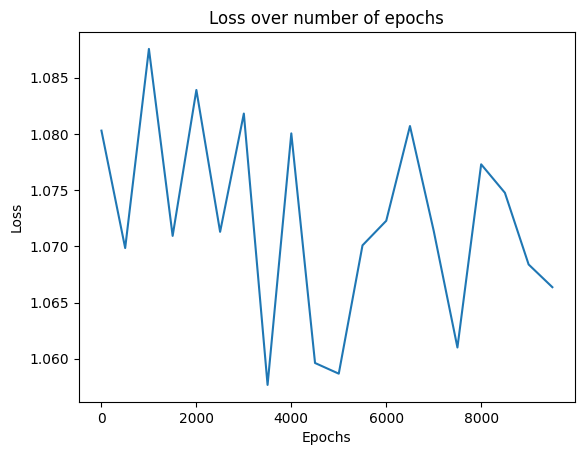

In [15]:
# Save the model
# torch.save(encoder, 'Model/encoder1.pt')
# torch.save(decoder, 'Model1/decoder1.pt')

# Plot loss over number of epochs
plt.plot(range(1, num_epochs+1), plot_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

plt.plot(range(1, num_epochs+1, display_interval), plot_avg_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

In [16]:
# LSTM evaluate
def LSTMevaluate(encoder, decoder, sentence, aspect, max_length=MAX_LENGTH):
    with torch.no_grad():
        input = preprocess_data([sentence])[0]
        input_idx = [word_to_idx[word] for word in input]
        input_tensor = torch.LongTensor([[ind] for ind in input_idx])
        
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()
        
        asp_idx = word_to_idx[aspect]
        asp_tensor = torch.LongTensor([[asp_idx]])

        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            _, encoder_hidden, _ = encoder(input_tensor[ei], encoder_hidden)
            encoder_hiddens[ei] += encoder_hidden[0, 0]
        
        y_pred = decoder(encoder_hidden, encoder_hiddens)
        topv, topi = y_pred.data.topk(1)
        return idx_to_polarity[topi.item()]

In [17]:
# Measure accuracy of LSTM model on test set
correct = 0
for i in range(len(test_x)):
    polarity = LSTMevaluate(encoder, decoder, test_x[i], test_a[i])
    if polarity == test_y[i]:
        correct += 1
accuracy = correct / len(test_x_token)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4373
